In [2]:
#Importing libraries
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
from azureml.widgets import RunDetails
from azureml.core import Run
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails
import mlflow

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [26]:
#Creating the workspace
ws = Workspace.from_config()

#Linkg workspace with mlflow
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())


In [8]:
dataset = Dataset.get_by_name(ws, name='AirlinesDelay')
#df = dataset.to_pandas_dataframe()

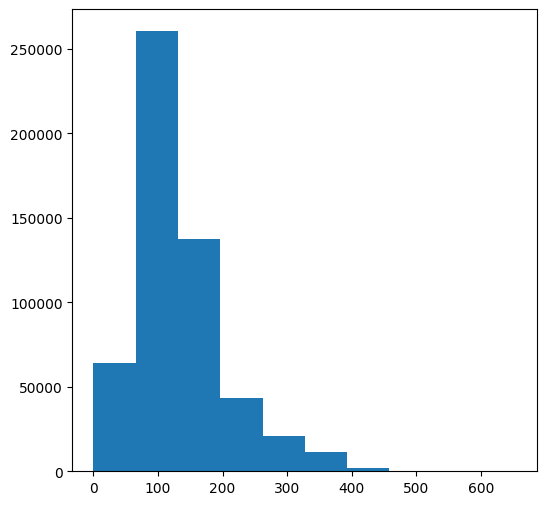

Plot listo!


In [43]:
#%%writefile experiments/mlflow_eda.py
from funcs.myfuncs import cln_data
experiment_name ='exp-prueba'
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    
    #loading data 
    #dataset = Dataset.get_by_name(ws, name='AirlinesDelay')
    df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")
    
    #Distribution of the target column
    class_cero, class_one = df['Class'].value_counts()
    mlflow.log_metrics({'one':class_one, 'cero':class_cero})
    
    #Comparation of the mean
    cls_one_df = df.loc[df['Class']==1]
    mean_one = cls_one_df['Time'].mean()
    
    cls_cero_df = df.loc[df['Class']==0]
    mean_cero = cls_cero_df['Time'].mean()
    
    mlflow.log_metrics({'mean cero':mean_cero, 'mean one':mean_one})

    #plot distribution of time
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()    
    plt.hist(df['Length'])
    plt.show()
    mlflow.log_figure(fig, "plot.png")
    print("Plot listo!")

    cl_df = cln_data(df)
    cl_df.to_csv('./clean_data.csv')
    mlflow.log_artifact('./clean_data.csv')
    
    
    #fig = plt.bar(x=['0','1'], height=[class_cero, class_one])
    #mlflow.log_figure(fig, 'plot.png')
    
    

In [4]:
df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")

df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [6]:
#How many airlines are
len(df['Airline'].unique())

#flights per aeroline
count_airline_flights = df['Airline'].value_counts().to_dict()
print(count_airline_flights)
#plt.bar(x=count_airline.keys,height=count_airline.values())

#airports
print(len(df['AirportFrom'].unique()))
#5 aeropuestos donde mas vuelon salen
print(df['AirportFrom'].value_counts().sort_values(ascending=False).head(5))
print(df['AirportFrom'].value_counts().sort_values(ascending=True).head(5))
#print(df['AirportFrom'].sort_values().tail(5))

print(len(df['AirportTo'].unique()))

print(df['AirportTo'].value_counts().sort_values(ascending=False).head(5))
print(df['AirportTo'].value_counts().sort_values(ascending=True).head(5))

#DaysWeek
dict_day_of_week= {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7: 'Sunday'}

df_day_of_week = df.replace({"DayOfWeek": dict_day_of_week},inplace=False)

df_day_of_week['DayOfWeek'].value_counts().to_dict()

#Correlación entre variables
df[['Time', 'Length', 'Class']].corr()

{'WN': 94097, 'DL': 60940, 'OO': 50254, 'AA': 45656, 'MQ': 36604, 'US': 34500, 'XE': 31126, 'EV': 27983, 'UA': 27619, 'CO': 21118, 'FL': 20827, '9E': 20686, 'B6': 18112, 'YV': 13725, 'OH': 12630, 'AS': 11471, 'F9': 6456, 'HA': 5578}
293
ATL    34449
ORD    24822
DFW    22153
DEN    19843
LAX    16657
Name: AirportFrom, dtype: int64
ABR     2
ADK     9
GUM    10
SJT    15
MMH    16
Name: AirportFrom, dtype: int64
293
ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
Name: AirportTo, dtype: int64
ABR     2
ADK     9
GUM    10
SJT    15
MMH    16
Name: AirportTo, dtype: int64


,Time,Length,Class
Time,1.000000,-0.020610,0.150457
Length,-0.020610,1.000000,0.040488
Class,0.150457,0.040488,1.000000


In [11]:
#cls_one_df = df.loc[df['Class']==1]
#mean_one = cls_one_df['Time'].mean()
    
#cls_cero_df = df.loc[df['Class']==0]
#mean_cero = cls_cero_df['Time'].mean()

df[['Time','Length', 'Class']].groupby('Class').mean().to_dict()

{'Time': {0: 765.2351379723052, 1: 849.4053083275064},
 'Length': {0: 129.65776048248517, 1: 135.3696974994173}}

In [14]:
# Ambiente para el experimento
env = Environment.from_conda_specification("env_exploratorio", "./env/environment.yml")

script_mlflow = ScriptRunConfig(source_directory='./experiments/',
                                script='mlflow_eda.py',
                                environment=env,
                                docker_runtime_config=DockerConfiguration(use_docker=True)) 

# submit the experiment
experiment = Experiment(workspace=ws, name='exp-prueba')

run = experiment.submit(config=script_mlflow)
run.wait_for_completion()


No Python version provided, defaulting to "3.8.13"


In [5]:
mlflow.end_run()

## Preprocessing

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")

def clean_data(data:pd.DataFrame) -> pd.DataFrame:
    '''
    Delete the Fligh column
    input: dataset
    output: pandas dataframe withiout Flight
    '''
    clean_df = data.drop('Flight', axis=1, inplace=False)
    return clean_df

def preprocess_data(data:pd.DataFrame) -> pd.DataFrame:
    numeric_columns = ['Length','Time']
    category_columns = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']

    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))])

    preprocessor = ColumnTransformer(
                        transformers=[
                            ('numeric', numeric_transformer, numeric_columns),
                            ('cat', categorical_transformer, category_columns)
                        ],
                        remainder='passthrough'
                    )
    
    #split the dependent(y) and independent(df_x) features 
    df_X = data.drop('Class', axis=1, inplace=False)
    y = data['Class']

    preprocessed_data = preprocessor.fit_transform(df_X)

    print(preprocessor.get_features_name_out_)
    return 'preprocessed_data'



df_new = clean_data(df)
processed_df = preprocess_data(df_new)

#df_new.head()

c:\Users\pablo.tamayo\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: 'ColumnTransformer' object has no attribute 'get_features_name_out_'

In [8]:
!conda env export > ./env/environment.yml